## Introduction
Project 2 will continue the work with census data from [Project 1](https://gist.github.com/kjprice/820c75bd8e5c3f2558f4576f38893dae) and the [Mini Project](https://gist.github.com/kjprice/bb3ecd63e7a2e5050c018d63c875a79b), to take a deeper look into the data. The analysis of this project will focus on the predictive classification ability.  Methods for both categorical variables as well as continuous variables will be evaluated.  

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

# load in raw dataset
person_raw = pd.read_csv('../data/person-subset-2.5percent.csv')

# clean data (as performed in Project 1)
# will provide us with a new dataset "df"
# ...and a list of "important_features"
execfile('../python/clean_data_person.py')

The `important_features` discovered from the first project will continue to be utilized in this project.

In [2]:
df[important_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 60356
Data columns (total 15 columns):
PINCP        60357 non-null float64
POVPIP       57892 non-null float64
JWMNP        32486 non-null float64
AGEP         60357 non-null int64
PWGTP        60357 non-null int64
PAP          60357 non-null float64
CIT          60357 non-null object
ENG          60357 non-null object
COW          60357 non-null object
PUMA         60357 non-null category
SEX          60357 non-null object
MIL          60357 non-null object
SCHL         60357 non-null float64
MAR          60357 non-null object
affluency    60312 non-null category
dtypes: category(2), float64(5), int64(2), object(6)
memory usage: 6.6+ MB


### Data Descriptions

The included attributes with descriptions:
  * AGEP:  Age of person (continuous 0-95)
  * CIT:  Citizenship status (categorical - numerical key)
  * CIT_CAT:  Citizenship status (categorical - string)
  * COW:  Class of worker (categorical - string)
  * ENG:  Ability to speak English (categorical scale of 1-4 and native speakers)
  * JWMNP:  Travel time to work (continuous - minutes of commute to work)
  * JWTR:  Means of transportation to work (categorical - 12 modes of transportation)
  * MAR:  Marital status (categorical - 5 categories: married, divorced, separated, single, widow)
  * PAP:  Public assistance income past 12 months (continuous variable of dollars of assistance received)
  * PINCP:  Total person's income (continuous of total income)
  * POVPIP:  Income-to-poverty ratio recode (continuous with a cap at 501)
  * SCHL:  Educational attainment (continuous - years of completed education)
  * SEX:  Sex (gender of female or male)

### Classification variable

A new variable has been created to categorize wealth.   The new variable called `affluency` which can be one of two levels - "general" or "rich" (greater than $100,000 income):

In [3]:
def create_affluency():
    global lr
    global important_features

    lr = df[important_features].copy(deep=True)
    lr['affluency'] = pd.cut(df.PINCP, [-1, 99999.99, 1e12], labels=('general', 'rich'))
create_affluency()

### Cleanup

As performed in the previous project, unneccesaary variables are removed from the dataset: 
 - `POVPIP`
 - `PINCP`
 - `PUMA`
 - `MIL`
 - `MAR`
 - `SCHL`

The "Travel Time" (`JWMNP`) attributed is grouped into appropriate intervals (previously a continuous variable):
 - `na`
 - `short`
 - `half hour`
 - `hour`
 - `long`
 
Then, from the variables `affluency` and `SEX`, boolean variables of `wealthy` and `is_male` are created respectively.

Finally, one-hot-encoding is performed on other categorical variables `travel_time`, `CIT`, `ENG`, `COW`.

All of this gives the following:

In [4]:
execfile('../python/clean_data_classification.py')
lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 60356
Data columns (total 49 columns):
PINCP                                              60357 non-null float64
AGEP                                               60357 non-null int64
PWGTP                                              60357 non-null int64
PAP                                                60357 non-null float64
wealthy                                            60357 non-null bool
is_male                                            60357 non-null int32
Travel_Time__na                                    60357 non-null uint8
Travel_Time__short                                 60357 non-null uint8
Travel_Time__half hour                             60357 non-null uint8
Travel_Time__hour                                  60357 non-null uint8
Travel_Time__long                                  60357 non-null uint8
Citizen__Born Abroad)                              60357 non-null uint8
Citizen__Naturalized    

### PCA

A principal components analysis is also performed with five components on a scaled-version of our dataset. Although the PCA is not officially part of the classification analysis, the data may be useful for comparative reference. 

In [5]:
df[pca_features].head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
0,1.884722,1.800257,0.924182,-0.699642,-0.178168
1,0.337951,-1.349852,0.459928,-0.865060,0.822004
2,-1.203093,-0.315044,-0.527054,-0.989047,1.147478
3,-0.173147,-1.279213,-0.209784,-0.614139,-0.449462
4,1.361579,1.421788,-0.016835,-1.109768,0.966580


## Evaluation metric

Ultimately, the object is to classify individuals as either _wealthy_ (income > \$100,000) or _general_ (income < \$100,000). Being so, the model should be as accurate as possible and analysis will consider accuracy to be the most important metric.

The dataset is highly unbalanced with only 7% of the population being classified as "wealthy". With an unbalanced dataset, the accuracy may be misleading because 92% of the accuracy is obtained by all individuals as "general."  Because of the unbalance in the dataset, the F-measure will be evaluated.  The F-measure will be a secondary metric to accuracy since it is a metric of precision and recall

For regression, we will use r^2 as the metric. This will give us a metric which is on the same scale as accuracy.

## Dividing Data

To help ensure that overfitting is mitigated, the 10-fold cross validation technique will be used to split the dataset. Because the dataset is so unbalanced, the stratified k-fold cross validator will be used.

Additionally, the dataset will be scaled so various classification techniques can be used.

In [6]:
def get_X_y(regression=False):
   global lr2
   lr2 = lr.copy(deep=True)
   y = list(lr2.wealthy.values)
   if regression:
       y = list(lr2.PINCP.values)
   del lr2['wealthy']
   del lr2['PINCP']
   X = lr2.values
   
   ### Standardize X values
   scl_obj = MinMaxScaler()
   scl_obj.fit(X)
   X = scl_obj.transform(X)
 
   return (X,y)

## Creating models

As mentioned earlier, the analysis will include both classification models predicting the feature wealthy.   Also, models will use regression to predict the feature income.   

Classification models will include Decision Tree, Naïve Bayes (Multinomial, Bernoulli, Gaussian), Stochastic Gradient Descent, and KNN.  

Regression models will include Decision Tree Regression, Ridge Regression, and LASSO Regression.

### Helper functions

Two functions are created to assist with the cognitive overload and clean the data and the code for each classification and regression model.   

The first function defines the statistical output.  The second function includes the cross validations along with control of the boolean or continuous variable in the resulting dataset. 

In [7]:
# variables to be used later
methodSpeeds = []
methodSpeedNames = []
_results = []
names = []

def print_accuracy(title, results):
    accuracy = round(results.mean()*100, 2)
    std = round(results.std(), 6)
    print('%s%% accuracy (%s std) - %s' % (accuracy, std, title))

def fit_and_test(title, model, show_individual_accuracies=False, print_confusion=False, regression=False, scoring='accuracy'):
    startTime = datetime.now()

    X, y = get_X_y(regression)
    
    cv_results = model_selection.cross_val_score(model, X, y, cv=10, scoring=scoring)
    
    _results.append(cv_results)
    names.append(title)
    
    print_accuracy(title, cv_results)

    methodSpeedNames.append(model.__class__.__name__)
    timePassed = datetime.now() - startTime
    methodSpeeds.append(timePassed.total_seconds())

### Decision Trees

In [8]:
dt_clf = DecisionTreeClassifier(max_features=None, class_weight='balanced')
fit_and_test('decision tree (no max feature)', dt_clf)
dt_clf = DecisionTreeClassifier(max_features=4, class_weight='balanced')
fit_and_test('decision tree (max_features=4)', dt_clf)
dt_clf = RandomForestClassifier(max_features=None, class_weight='balanced')
fit_and_test('Random Forest', dt_clf)

89.7% accuracy (0.002904 std) - decision tree (no max feature)
89.67% accuracy (0.002594 std) - decision tree (max_features=4)
92.53% accuracy (0.001812 std) - Random Forest


The decision tree provides **90%** accuracy.  Only a slight accuracy improvement is seen when limiting the features (‘max features =4’).   Using the random forest provides a more substantial boost with an accuracy of about **92%** total.

### Multinomial Bayes

In [9]:
mb_clf = MultinomialNB(alpha=100)
fit_and_test('bayes multinomial (alpha=100)', mb_clf, show_individual_accuracies=False)
mb_clf = MultinomialNB(alpha=1)
fit_and_test('bayes multinomial (alpha=1)', mb_clf, show_individual_accuracies=False)
mb_clf = MultinomialNB(alpha=.001)
fit_and_test('bayes multinomial (alpha=.001)', mb_clf, show_individual_accuracies=False)

92.74% accuracy (0.001426 std) - bayes multinomial (alpha=100)
92.82% accuracy (0.001239 std) - bayes multinomial (alpha=1)
92.82% accuracy (0.001171 std) - bayes multinomial (alpha=.001)


The multinomial Bayes has an accuracy around **93%** consistently.  Adjustments in the `alpha` parameter do not seem to produce a significant change in accuracy.

### Bernoulli Bayes

In [10]:
mb_clf = BernoulliNB(alpha=100)
title_with_params = 'bayes bernoulli alpha=100, binarize=None'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=.1)
title_with_params = 'bayes bernoulli alpha=0.1, binarize=None'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=.1, binarize=1)

print('')

title_with_params = 'bayes bernoulli alpha=0.1, binarize=1'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)
mb_clf = BernoulliNB(alpha=100, binarize=1)
title_with_params = 'bayes bernoulli alpha=100, binarize=1'
fit_and_test(title_with_params, mb_clf, show_individual_accuracies=False)


92.03% accuracy (0.002165 std) - bayes bernoulli alpha=100, binarize=None
91.35% accuracy (0.002516 std) - bayes bernoulli alpha=0.1, binarize=None

92.68% accuracy (6e-06 std) - bayes bernoulli alpha=0.1, binarize=1
92.68% accuracy (6e-06 std) - bayes bernoulli alpha=100, binarize=1


Bernoulli Bayes gives about **92%** accuracy with a slight gain for setting the property `binarize=1`.

### Gaussian Bayes

In [11]:
mb_clf = GaussianNB()
fit_and_test('bayes gaussian', mb_clf, show_individual_accuracies=False)

42.82% accuracy (0.005449 std) - bayes gaussian


The Gaussian Bayes performs terribly. Many of the dataset features are nominal or binomial, so the performance is expected since Gaussian Bayes performs best with normally distributed data.  Even with the assumption of normal distribution unmet, the fact that this model performs worse than a random guess might do (less than 50%) is pretty startling.

### Gradient Descent

In [12]:
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const, class_weight='balanced',
       fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
       loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

fit_and_test('gradient descent', svm_sgd, show_individual_accuracies=False)

72.05% accuracy (0.011006 std) - gradient descent


Stochastic gradient descent does not perform as well as the some previous models.  The gradient descent would not be an accurate model for this particular dataset.  

### KNN (k-nearest neighbor)

In [13]:
def run_knn():
    ## seems to default to kd_tree
    ## TODO: see if parameters can be used to tweak
    knn_clf = KNeighborsClassifier()
    fit_and_test('knn', knn_clf, show_individual_accuracies=False)

run_knn()

92.5% accuracy (0.001742 std) - knn


The KNN model provides an accuracy as high as the Decision Tree; however, due to the dataset size, the model is not an effienct one to use.  

### Decision Tree Regressor

In [14]:
dt_reg = DecisionTreeRegressor(max_depth=5)
fit_and_test("Decision Tree Regressor", dt_reg, regression=True, scoring='r2')

23.58% accuracy (0.019461 std) - Decision Tree Regressor


Our metric is no longer _accuracy_, because this is a regression function, but instead we are using _r^2_. The decision tree regressor gives us an r^2 of around **23%**.

### Ridge Regression

In [15]:
from sklearn.linear_model import Ridge

def ridge_reg():
    ridge_reg = Ridge(alpha=.05, normalize=True)
    fit_and_test("Ridge Regressor", ridge_reg, regression=True, scoring='r2')
    return
   
ridge_reg()

28.24% accuracy (0.00946 std) - Ridge Regressor


The ridge regression adds a factor of sum of squares to the coefficients and also uses the r^2.  The results of around **28%** are higher that the decision tree regressor; however, the results are still not as statistically valuable as the classification models.

### LASSO Regression

In [17]:
from sklearn.linear_model import Lasso

def lasso_reg():
    lasso_reg = Lasso(alpha=.05, normalize=True, max_iter=1e5)
    fit_and_test("Lasso Regressor", lasso_reg, regression=True, scoring='r2')
    return
   
lasso_reg()

28.28% accuracy (0.009837 std) - Lasso Regressor


The LASSO regression (least absolute shrinkage and selection operator) will also rely on the r^2 for the accuracy of the prediction.   The LASSO regression results are also about **28%** which is comparable to ridge regression.   

The regression models were less successful with the predictive modeling than the classification models.   


## Analyze Results


The results of the models will be compared.  Since nine models with various arguements have been run, the comparison will only include those with _accuracy_ (for classification) and _r^2_  (for regression) greater then 80%. 

### Compare Metrics

Here the top-performing models are compared using box plots of the accuracies for the 10fold cross validation. The Bayes multinomial model, with alpha set to .001 seems to provide the highest accuracy with moderate variance. If variance was an issue, then the Bernoulli Bayes model would be used.

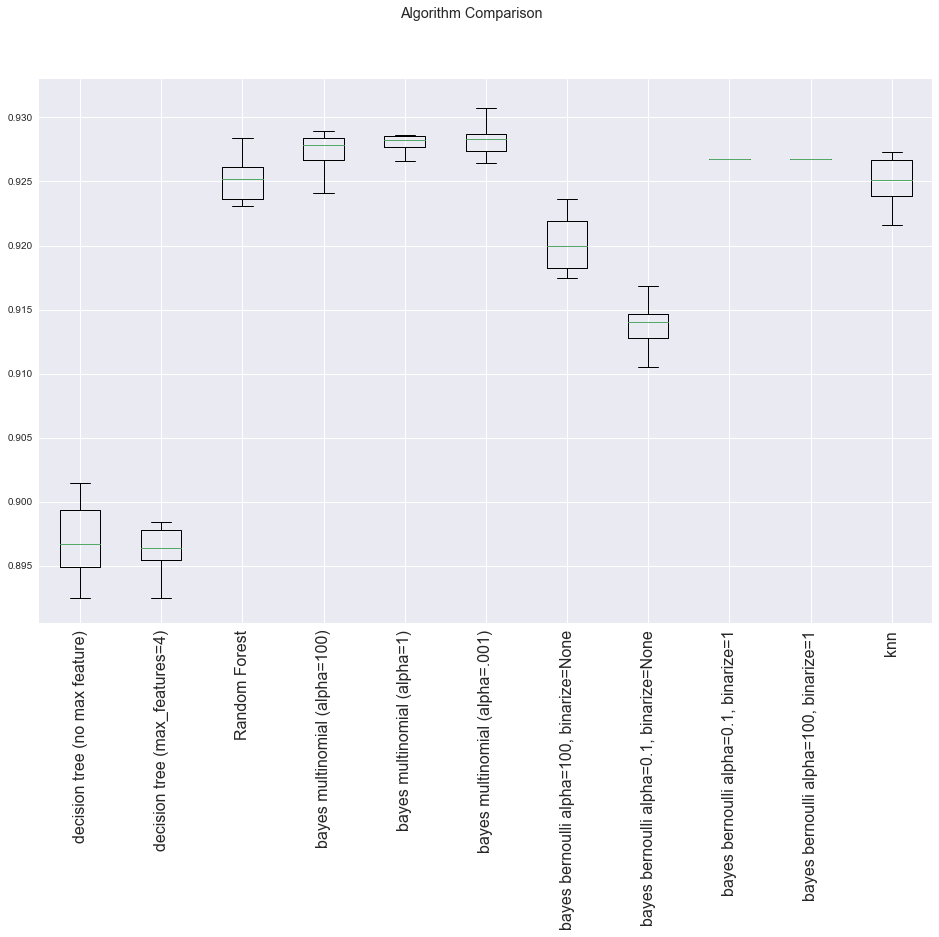

In [18]:
###Comparison of Algorithms
x_results = pd.Series(_results)
x_names = pd.Series(names)
def showAlgorithmMetricPlots(items_index):
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(x_results[items_index])
    ax.set_xticklabels(x_names[items_index], rotation=90, fontsize=16)
    plt.show()

showAlgorithmMetricPlots(x_results.map(np.mean) > .8)


### Statistically compare models

The box plot clearly shows the difference between the accuracies between models.   Before continuing with assumptions about the accuracies, the F-Statistic (and p-value) for the first six models will be analyzed.   The f-statistic and p-value requires the assumption of normality and equal variance.  Normality can be assumed, but equal variance is still under scrutiny.  

In [19]:
F, p = stats.f_oneway(_results[0], _results[1], _results[2], _results[3], _results[4], _results[5])
print ('F statistic %s and p-value %s' %(F, p))

F statistic 571.833286361 and p-value 1.8961295352e-45


Clearly, there is overwhelming evidence to suggest that at least one of the models has a different mean. Review of the t-test statistic of the two highest-performing bayes models (one model with an alpha of 1 and the other with an alpha of .001) will provide more information.

In [20]:
t, p = stats.ttest_ind(_results[4], _results[5])
print ('T statistic %s and p-value %s' %(t, p))

T statistic -0.0874468434361 and p-value 0.931281834641


With such a large p-value, it is not possible to reject the assumption that the two distributions have the same mean.

### Compare Time to complete

The computation time of each function is evaluated.  The results provide in seconds the time to model both the training and the testing set.  

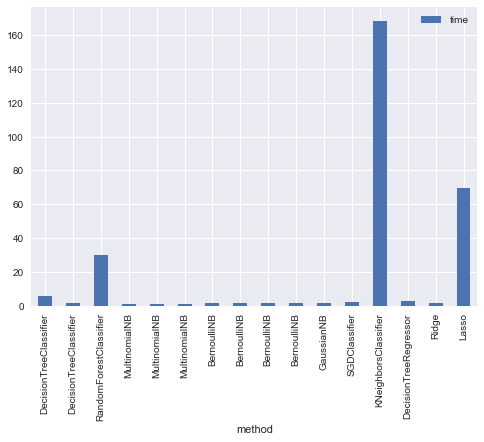

In [21]:
def showSpeedPlot():
   speeds = pd.DataFrame({'method': methodSpeedNames, 'time': methodSpeeds})
   speeds.plot.bar(x='method', y='time')
   plt.show()
showSpeedPlot()

The Multinomial Bayes model is clearly the fastest model. Based on the analysis, the Multinomial Bayes models gives both the best accuracy and is the fastest compared to all other classification techniques explored. However, no convincing evidence is provided that a change in an alpha can give us better accuracy on our Multinomial Bayes model.

### Compare F1 score

Because the dataset is so unbalanced, it would be wise to check the F1 score to take a look at precision and recall. Since the Multinomial Bayes model has the best accuracy, the statistic for that model will be computed:

In [22]:
X, y = get_X_y()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2, random_state=42)

mb_clf = MultinomialNB(alpha=1)
mb_clf.fit(X_train, y_train)

y_hat = mb_clf.predict(X_test)

acc = mt.accuracy_score(y_test, y_hat)
print(mt.confusion_matrix(y_test, y_hat))
print('F1 score %s' % mt.f1_score(y_test, y_hat))

[[10997   182]
 [  679   214]]
F1 score 0.33204034135


The confusion matrix and the F1 score both confirm the issue with large unblanced datasets.  Three times as many people incorrectly classifed as "general" (679) as there were correctly classified as "wealthy" (214).  A small F1 score further confirms the concerns.  A larger F1 score would be more beneficial; however, with an unbalanced dataset, the score may be the best possible score.  Analysis will continue with caution.

## Most important features

With Multinomial Bayes being the strongest model for accuracy, the coefficients are calculated from fitting the model.

In [23]:
X, y = get_X_y()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2)

mb_clf = MultinomialNB(alpha=1)
mb_clf.fit(X_train, y_train)

chosen_coeficients = pd.Series(mb_clf.coef_[0])
chosen_coeficients.index = lr2.columns
chosen_coeficients = chosen_coeficients.sort_values()

# All coefficients seem to be negative, let's offset them to show some positive weights
chosen_coeficients + 7

Worker_Class__Unemployeed                         -3.283832
PAP                                               -1.972800
English__Not at all                               -1.897538
Education_Attained__na                            -1.492073
Worker_Class__Family Business - no pay            -1.204390
Education_Attained__no_high_school                -0.981247
Citizen__US Territory Born                        -0.644775
Miliary_Service__Serving Active Duty              -0.288100
English__Not well                                 -0.148338
Marital_status__Separated                          0.242528
Citizen__Born Abroad)                              0.327086
Education_Attained__some_high_school               0.353754
Miliary_Service__Reserves                          1.135009
English__Well                                      1.270045
Worker_Class__State Government                     1.398299
Marital_status__Widowed                            1.469758
Citizen__Non-Citizen                    

Clearly never being in the military seems to be an important feature. Additional research might be warranted into why this feature is so important.

Other features seem less surprising: Being married, born in US, and only speaking English are the next most important positive features. The most important negative features are: being unemployed, receiving public assistance in the last 12 months (`PAP`), and not speaking English.

## Deployment

The model achieves about 93% accuracy. We may want to work on getting the accuracy up higher as you could, theoretically, get about 92% by naively classifying all people as "general" wealth.

For true classification, we would want to see this model in production. To deploy, we may want to use a low-level, compiled language such as Java to be in charge of handling the actual classification of real data.

The model could be useful for anyone guiding young adults on advice to have financially successful careers.   The data needs to be updated annually to reflect the new dataset from the US census.


## Exceptional Work

For exceptional work, two regression models were included in the analysis above.  An attempt was made for the kernel ridge regression; however, the computation resources were too great for local machine calculation.  